## In this notebook you can find a more difficult program that shows further high energy physics (HEP) analysis techniques.
### The following analysis is searching for events where Z bosons decay to two leptons of same flavour and opposite charge (to be seen for example in the   Feynman diagram).

##### This is the same analysis as in the C++ notebook found at https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/8-TeV-examples/cpp/ATLAS_OpenData_8-TeV_cpp_invariant_mass_reconstruction_using_TLorentz_vectors.ipynb



<img src="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/raw/0dab48823ece9ecf99fbff6e6968e8f91c21f211/images/Z_ElectronPositron.png" width="sitewidth"
    />


As a first step we load the required packages:  
- UnROOT: Used to read in .root files and converting the TTrees into a LazyTree.
- Plots: Plotting  
- FHist: Histogram generation 
- LorentzVectorHEP: Implementation of the TLorentzVector similar to TLorentzVector from ROOT.

In [13]:
using UnROOT
using Plots
using FHist
using LorentzVectorHEP

Next we define a function that converts the LorentzVector PtEtaPhiE to one that contains the mass instead of the energy.  


In [14]:
function LorentzVectorCylE(pt, eta, phi, E) # Takes pt eta phi E and return a LorentzVector with pt eta phi mass
  m2 = E^2 - pt^2 - (sinh(eta) * pt)^2# Calculates the squared mass M2()
  m  =sign(m2) * sqrt(abs(m2)) 
  return LorentzVectorCyl(pt,eta,phi,m) #returns the LorentzVector
end




LorentzVectorCylE (generic function with 1 method)

Next we have to open the data that we want to analyze. It is stored in a `*.root file.`   
We load our data using the `LazyTree` and `ROOTFile` functions.

In [15]:
tree = UnROOT.LazyTree(UnROOT.ROOTFile("http://opendata.atlas.cern/release/samples/MC/mc_147770.Zee.root"), "mini", ["lep_n", "lep_charge", "lep_type", "lep_pt", "lep_phi", "lep_eta", "lep_E"])


,lep_n,lep_eta,lep_type,lep_pt,lep_E,lep_phi,lep_charge
,UInt32,SubArray{Float3,SubArray{UInt32,SubArray{Float3,SubArray{Float3,SubArray{Float3,SubArray{Float3
1,1,[1.71],[11],[29800.0],[85100.0],[-2.79],[-1.0]
2,2,"[2.25, 2.12]","[11, 11]","[93100.0, 20100.0]","[446000.0, 84500.0]","[1.85, -0.883]","[-1.0, 1.0]"
3,2,"[-0.872, -1.63]","[11, 11]","[43200.0, 37300.0]","[60700.0, 98700.0]","[2.48, -0.678]","[1.0, -1.0]"
4,1,[-1.13],[11],[72200.0],[123000.0],[0.96],[1.0]
5,1,[1.8],[11],[45100.0],[140000.0],[-0.987],[1.0]
6,2,"[0.396, 2.2]","[11, 11]","[67700.0, 15000.0]","[73100.0, 68300.0]","[2.21, -1.42]","[-1.0, 1.0]"
7,2,"[1.23, 1.25]","[11, 11]","[116000.0, 19500.0]","[216000.0, 36900.0]","[1.05, -2.66]","[-1.0, 1.0]"
8,1,[-1.9],[11],[31800.0],[109000.0],[-2.46],[1.0]
9,2,"[1.57, 1.6]","[11, 11]","[58900.0, 34400.0]","[148000.0, 88600.0]","[0.269, -2.39]","[1.0, -1.0]"


`tree` is a `LazyTree?` object containing selected branches of the TTree "mini", if no branches are specified tree will contain all branches.

Our first step is to select only the first 10% of the events, this can be done using `Iterators.take()`, iterators are lazy and will only allocate the required data when it's needed.

In [16]:
fraction_events = 0.1
events_to_run = Int(length(tree) * fraction_events) #Total events: 7.500.000 -> We only want to take 750.000.
tree = Iterators.take(tree, events_to_run);



## Data selection

Now we want to cut parts of our data to the specified requirements that we are looking for.  
 This is done with the Iterators.filter() function which filters events for which the given condition is true.  This is a lazy operation as well and won't allocate memory until we access the data.

### Cut 1: Exactly two leptons

In [17]:
tree = Iterators.filter(x->getproperty(x , :lep_n)==2, tree);

### Cut 2: Leptons with opposite charge
### `tree.lep_charge` contains arrays which each contain the charge of the leptons that are involved in the event of which we inspect the two leading ones.

In [18]:
tree = Iterators.filter(x->getproperty(x, :lep_charge)[1] != getproperty(x, :lep_charge)[2], tree);

### Cut 3: Leptons of the same family (`lep_type`)

In [19]:
tree = Iterators.filter(x->getproperty(x, :lep_type)[1] == getproperty(x, :lep_type)[2], tree);


## Histogram creation

Now we want to calculate the invariant masses for the events that we think show the decay of the Z boson in two leptons and fill a histogram with those.  
For that we create an empty histogram containing 30 equally spaced bins in the range from 40 to 140.

In [20]:
hist = FHist.Hist1D(Float64, bins = range(40, 140, 30), overflow=true)

┌                              ┐ 
   [ 40.0,  43.0) ┤  0.0                           
   [ 43.0,  46.0) ┤  0.0                           
   [ 47.0,  50.0) ┤  0.0                           
   [ 50.0,  53.0) ┤  0.0                           
   [ 54.0,  57.0) ┤  0.0                           
   [ 57.0,  60.0) ┤  0.0                           
   [ 61.0,  64.0) ┤  0.0                           
   [ 64.0,  67.0) ┤  0.0                           
   [ 68.0,  71.0) ┤  0.0                           
   [ 71.0,  74.0) ┤  0.0                           
   [ 74.0,  77.0) ┤  0.0                           
   [ 78.0,  81.0) ┤  0.0                           
   [ 81.0,  84.0) ┤  0.0                           
   [ 85.0,  88.0) ┤  0.0                           
   [ 88.0,  91.0) ┤  0.0                           
   [ 92.0,  95.0) ┤  0.0                           
   [ 95.0,  98.0) ┤  0.0                           
   [ 99.0, 102.0) ┤  0.0                           
   [102.0, 105.0) ┤  0.0                           
   [106.0, 109.0) ┤  0.0                           
   [109.0, 112.0) ┤  0.0                           
   [112.0, 115.0) ┤  0.0                           
   [116.0, 119.0) ┤  0.0                           
   [119.0, 122.0) ┤  0.0                           
   [123.0, 126.0) ┤  0.0                           
   [126.0, 129.0) ┤  0.0                           
   [130.0, 133.0) ┤  0.0                           
   [133.0, 136.0) ┤  0.0                           
   [137.0, 140.0) ┤  0.0                           
                  └                              ┘ 
edges: 40.0:3.4482758620689653:140.0
bin counts: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total count: 0.0

We use a for loop to calculate our LorentzVectors, calculate the invariant mass and add it (divided by 1000 so we get GeV instead of MeV) to our histogram.  
This temporarily allocates only the required memory for a single event while accessing it.  
`fast_mass` is a function from the *LorentzVectorHEP.jl* package that calculates the invariant mass of two Lorentz vectors.  
`atomic_push!` is a function from the *FHist.jl* package that fills the histogram.

In [21]:
for event in tree
    v1 = LorentzVectorCylE(event.lep_pt[1], event.lep_eta[1], event.lep_phi[1], event.lep_E[1])
    v2 = LorentzVectorCylE(event.lep_pt[2], event.lep_eta[2], event.lep_phi[2], event.lep_E[2])
    mass = fast_mass(v1, v2)
    atomic_push!(hist, mass/1000)
end

In [22]:
hist

┌                              ┐ 
   [ 40.0,  43.0) ┤▌ 3873.0                        
   [ 43.0,  46.0) ┤▍ 2234.0                        
   [ 47.0,  50.0) ┤▍ 2296.0                        
   [ 50.0,  53.0) ┤▍ 2194.0                        
   [ 54.0,  57.0) ┤▍ 2252.0                        
   [ 57.0,  60.0) ┤▍ 2233.0                        
   [ 61.0,  64.0) ┤▍ 2347.0                        
   [ 64.0,  67.0) ┤▍ 2640.0                        
   [ 68.0,  71.0) ┤▌ 3281.0                        
   [ 71.0,  74.0) ┤▋ 4304.0                        
   [ 74.0,  77.0) ┤▉ 6665.0                        
   [ 78.0,  81.0) ┤█▊ 12091.0                      
   [ 81.0,  84.0) ┤████▏ 27929.0                   
   [ 85.0,  88.0) ┤██████████▊ 74641.0             
   [ 88.0,  91.0) ┤████████████████████  137331.0  
   [ 92.0,  95.0) ┤██████████▍ 71387.0             
   [ 95.0,  98.0) ┤██▍ 16048.0                     
   [ 99.0, 102.0) ┤▊ 5848.0                        
   [102.0, 105.0) ┤▌ 2973.0                        
   [106.0, 109.0) ┤▍ 1902.0                        
   [109.0, 112.0) ┤▎ 1388.0                        
   [112.0, 115.0) ┤▎ 1015.0                        
   [116.0, 119.0) ┤▎ 784.0                         
   [119.0, 122.0) ┤▎ 657.0                         
   [123.0, 126.0) ┤▏ 499.0                         
   [126.0, 129.0) ┤▏ 450.0                         
   [130.0, 133.0) ┤▏ 347.0                         
   [133.0, 136.0) ┤▏ 300.0                         
   [137.0, 140.0) ┤▌ 3132.0                        
                  └                              ┘ 
edges: 40.0:3.4482758620689653:140.0
bin counts: [3873.0, 2234.0, 2296.0, 2194.0, 2252.0, 2233.0, 2347.0, 2640.0, 3281.0, 4304.0  …  1902.0, 1388.0, 1015.0, 784.0, 657.0, 499.0, 450.0, 347.0, 300.0, 3132.0]
total count: 393041.0

## Plotting the histogram

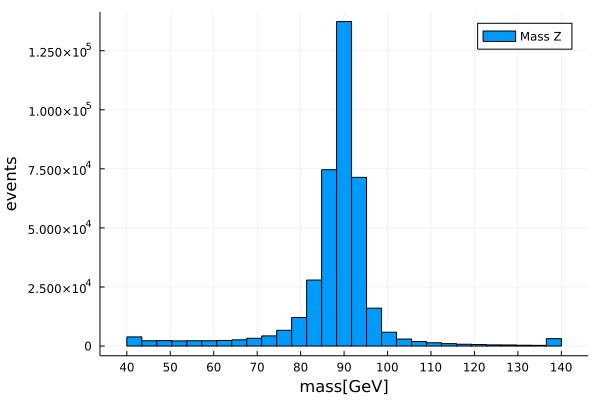

In [23]:
plot(hist,label="Mass Z",xlabel="mass[GeV]",ylabel="events",xticks=40:10:140)

### We can easily add some statistics to our plot.

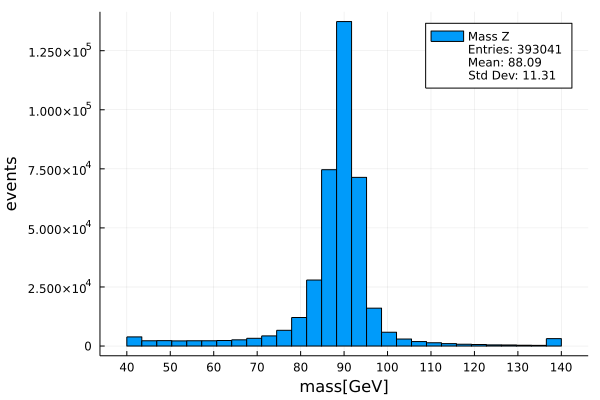

In [24]:
count_number = Int64(round(sum(hist.hist.weights), digits=0))
mean_value = round(mean(hist), digits = 2)
standard_dev = round(std(hist), digits=2)


plot!([], lc=:transparent, label="Entries: $count_number")
plot!([], lc=:transparent, label="Mean: $mean_value")
plot!([], lc=:transparent, label="Std Dev: $standard_dev")